<a href="https://colab.research.google.com/github/Taghr66d/MSc-SummerProject2025/blob/main/Whitening_Inject_Cusp_vs_Blip_in_Real_noise_(Acc_93_)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [8]:
import numpy as np

cusp_data = np.load("cusp_real_noise_whitened.npz")
blip_data = np.load("blip_real_noise_whitened_10k.npz")


X_blip = blip_data["X"]
y_blip = blip_data["y"]

X_cusp = cusp_data["X"]
y_cusp = cusp_data["y"]


# Combine and relabel (blip = 0, cusp = 1)
X = np.concatenate([X_blip, X_cusp], axis=0)
y = np.concatenate([np.zeros_like(y_blip), np.ones_like(y_cusp)], axis=0)


In [9]:
print(X_blip.shape)
print(X_cusp.shape)
print(X.shape)
print(y.shape)

(10000, 1024)
(10000, 1024)
(20000, 1024)
(20000,)


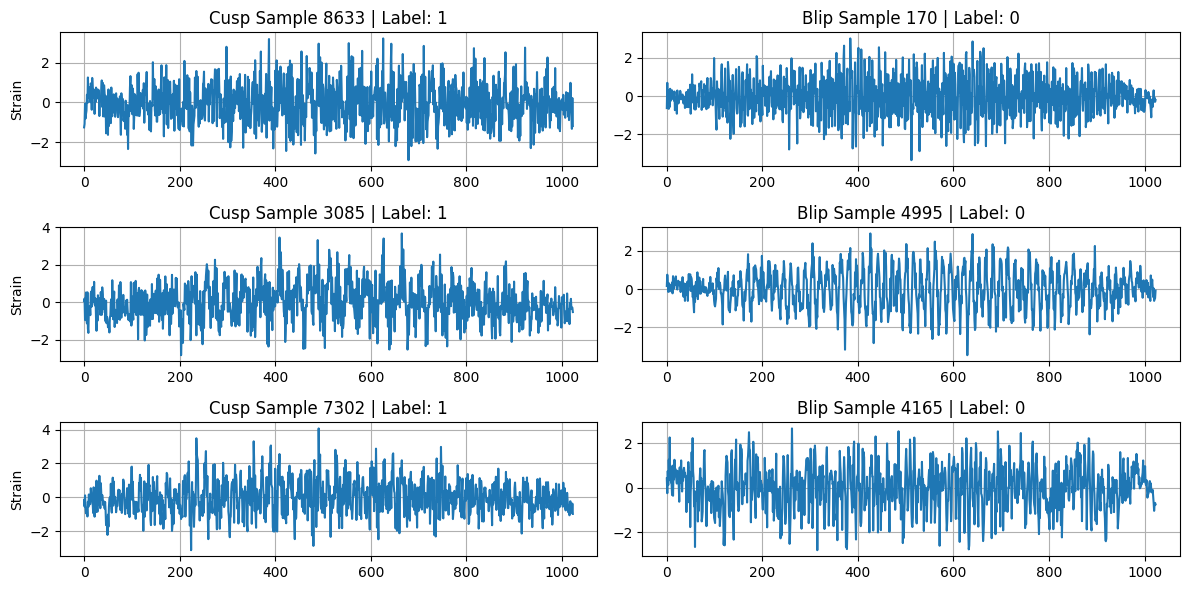

In [10]:
import numpy as np
import matplotlib.pyplot as plt


X1 = cusp_data["X"]
y1 = cusp_data["y"]
X2 = blip_data["X"]
y2 = blip_data["y"]

n_samples = 3

plt.figure(figsize=(12, n_samples * 2))

for i in range(n_samples):
    # Random cusp sample
    idx1 = np.random.randint(0, len(X1))
    plt.subplot(n_samples, 2, i * 2 + 1)
    plt.plot(X1[idx1])
    plt.title(f"Cusp Sample {idx1} | Label: {int(y1[idx1])}")
    plt.ylabel("Strain")
    plt.grid(True)

    # Random blip sample
    idx2 = np.random.randint(0, len(X2))
    plt.subplot(n_samples, 2, i * 2 + 2)
    plt.plot(X2[idx2])
    plt.title(f"Blip Sample {idx2} | Label: {int(y2[idx2])}")
    plt.grid(True)

plt.tight_layout()
plt.show()


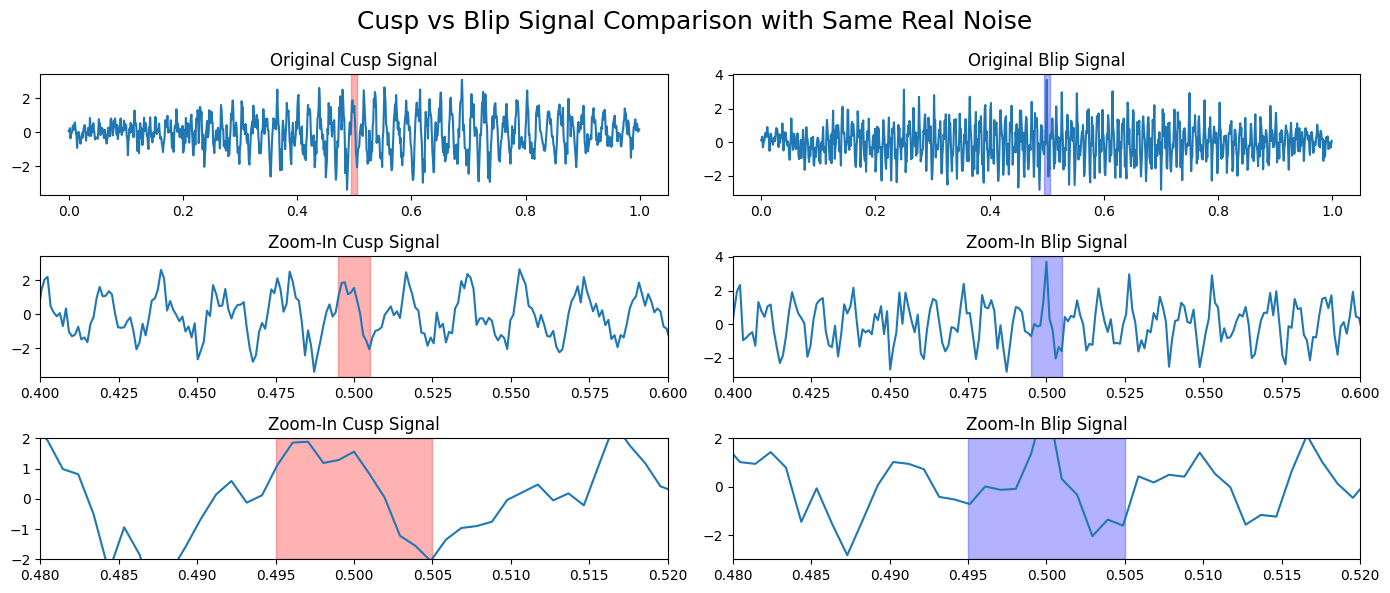

In [11]:

fs= 1024

signal_cusp = X_cusp[21]
signal_blip = X_blip[21]
t = np.arange(len(signal_cusp)) / fs

######## Cusp signal ##########
plt.figure(figsize=(14, 6))

plt.subplot(3, 2, 1)
plt.plot(t, signal_cusp)
plt.axvspan(0.495,0.505, color='r', alpha=0.3)
plt.title("Original Cusp Signal")

plt.subplot(3, 2, 3)
plt.plot(t, signal_cusp)
plt.axvspan(0.495,0.505, color='r', alpha=0.3)
plt.title("Zoom-In Cusp Signal")
plt.xlim(0.400, 0.600)

plt.subplot(3, 2, 5)
plt.plot(t, signal_cusp)
plt.axvspan(0.495,0.505, color='r', alpha=0.3)
plt.title("Zoom-In Cusp Signal")
plt.xlim(0.480, 0.520)
plt.ylim(-2, 2)


####### Blip Signal #########
plt.subplot(3, 2, 2)
plt.plot(t, signal_blip)
plt.axvspan(0.495,0.505, color='b', alpha=0.3)
plt.title("Original Blip Signal")

plt.subplot(3, 2, 4)
plt.plot(t, signal_blip)
plt.axvspan(0.495,0.505, color='b', alpha=0.3)
plt.title("Zoom-In Blip Signal")
plt.xlim(0.400, 0.600)

plt.subplot(3, 2, 6)
plt.plot(t, signal_blip)
plt.axvspan(0.495,0.505, color='b', alpha=0.3)
plt.title("Zoom-In Blip Signal")
plt.xlim(0.480, 0.520)
plt.ylim(-3, 2)

plt.suptitle("Cusp vs Blip Signal Comparison with Same Real Noise", fontsize=18)
plt.tight_layout()
plt.show()

In [12]:
# Reshape for CNN input
X = X[..., np.newaxis]  # shape = (samples, 1024, 1)

In [13]:
from sklearn.model_selection import train_test_split

def split_data(X, y, val_size=0.15, test_size=0.15):
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, val_size=0.15, test_size=0.15)


In [14]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


(14000, 1024, 1) (3000, 1024, 1) (3000, 1024, 1)
(14000,) (3000,) (3000,)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv1D(32, 7, activation='relu', input_shape=X.shape[1:]),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(64, 5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    GlobalAveragePooling1D(),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1018, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1018, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 509, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 505, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 505, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 252, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,169 (59.25 KB)

 Trainable params: 14,977 (58.50 KB)

 Non-trainable params: 192 (768.00 B)

In [16]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - accuracy: 0.6862 - loss: 0.5936 - val_accuracy: 0.6333 - val_loss: 0.6316
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.7662 - loss: 0.5020 - val_accuracy: 0.7943 - val_loss: 0.4645
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 167ms/step - accuracy: 0.8163 - loss: 0.4238 - val_accuracy: 0.6673 - val_loss: 0.6219
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - accuracy: 0.8411 - loss: 0.3730 - val_accuracy: 0.8433 - val_loss: 0.3634
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.8703 - loss: 0.3139 - val_accuracy: 0.8050 - val_loss: 0.3896
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 42s 174ms/step - accuracy: 0.9014 - loss: 0.2569 - val_accuracy: 0.9233 - val_loss: 0.2097
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.9140 - loss: 0.2192 - val_accuracy: 0.9203 - val_loss: 0.2085
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.9196 - loss: 0

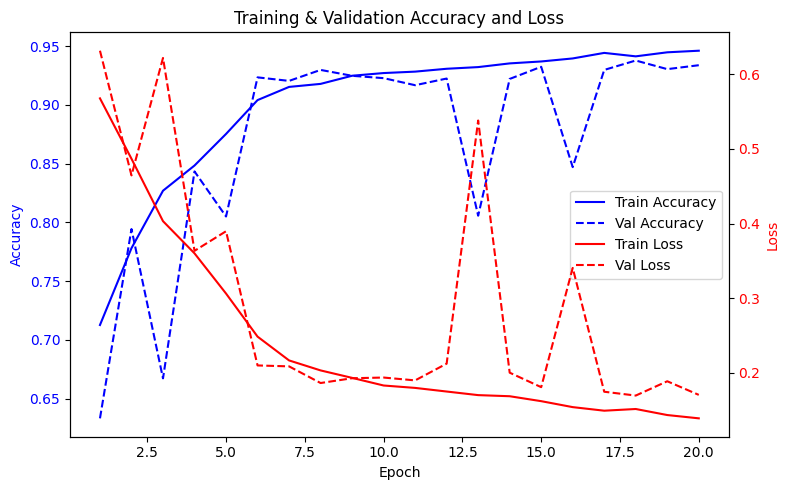

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))


ax1.plot(epochs, history.history['accuracy'], 'b-', label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], 'b--', label='Val Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')


ax2 = ax1.twinx()
ax2.plot(epochs, history.history['loss'], 'r-', label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], 'r--', label='Val Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right')

plt.title('Training & Validation Accuracy and Loss')
plt.tight_layout()
plt.show()

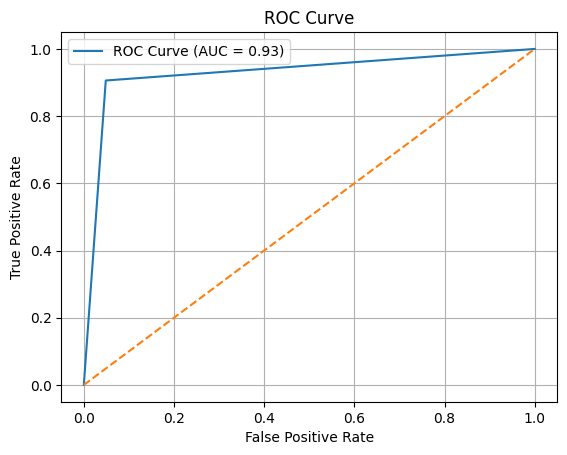

In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


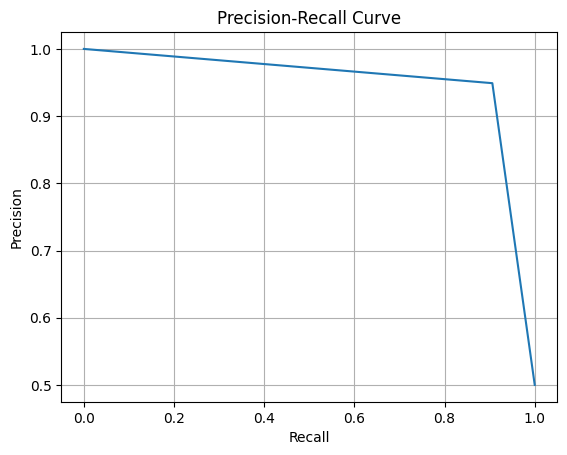

In [20]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9252 - loss: 0.1753
Test Accuracy: 0.9287, Test Loss: 0.1683


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


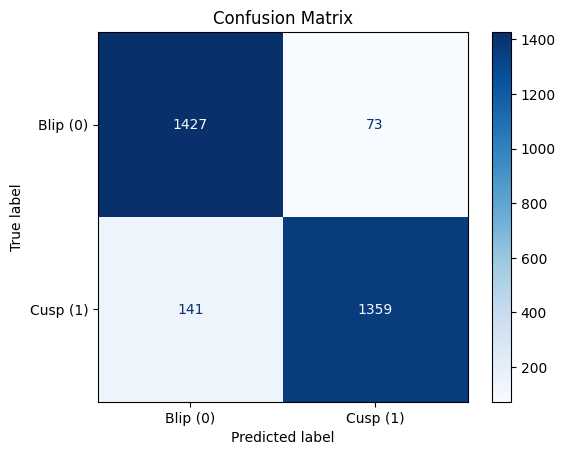

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

probs = model.predict(X_test)
y_pred = (probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Blip (0)", "Cusp (1)"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [25]:
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt


def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='band')


def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)


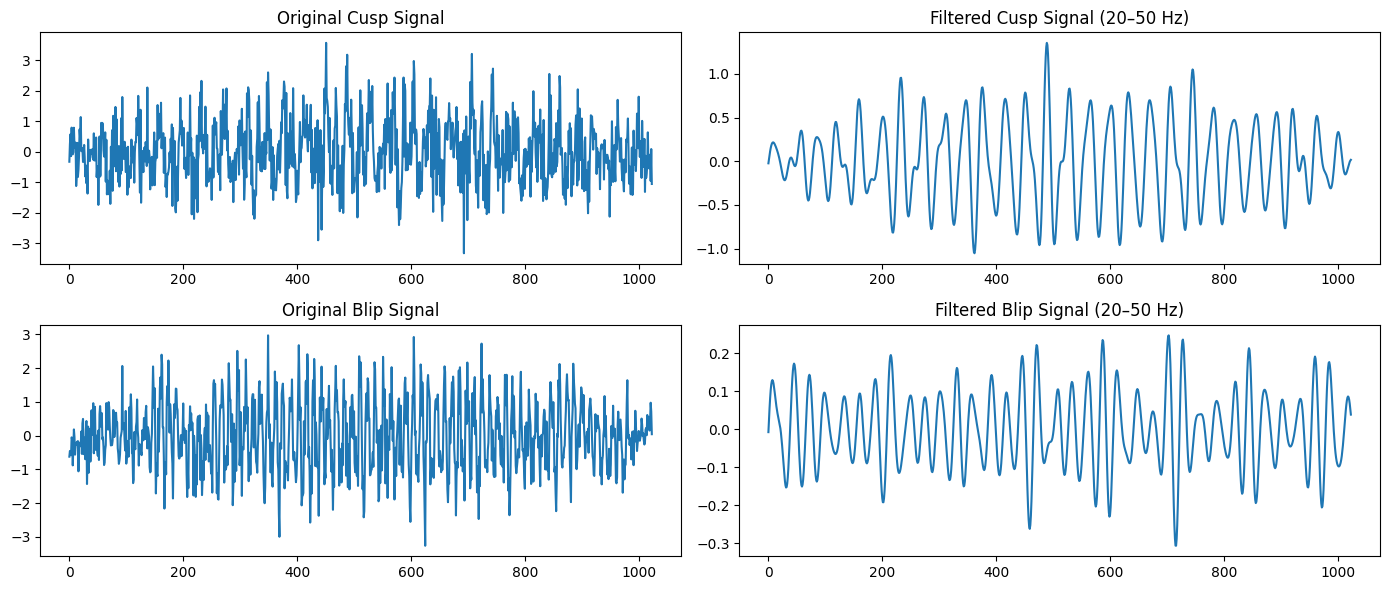

In [26]:
fs = 1024
lowcut = 20
highcut = 50

#sample
signal_cusp = X_cusp[1]
signal_blip = X_blip[4]

# Filter
filtered_cusp = apply_bandpass_filter(signal_cusp, lowcut, highcut, fs)
filtered_blip = apply_bandpass_filter(signal_blip, lowcut, highcut, fs)


plt.figure(figsize=(14, 6))

plt.subplot(2, 2, 1)
plt.plot(signal_cusp)
plt.title("Original Cusp Signal")
plt.subplot(2, 2, 2)
plt.plot(filtered_cusp)
plt.title("Filtered Cusp Signal (20–50 Hz)")

plt.subplot(2, 2, 3)
plt.plot(signal_blip)
plt.title("Original Blip Signal")
plt.subplot(2, 2, 4)
plt.plot(filtered_blip)
plt.title("Filtered Blip Signal (20–50 Hz)")

plt.tight_layout()
plt.show()

In [27]:
import tensorflow as tf
import numpy as np

index = 22
sample = X[index]  # shape: (1024,)
sample = sample[np.newaxis, :, np.newaxis]  # shape: (1, 1024, 1)


sample_tensor = tf.convert_to_tensor(sample, dtype=tf.float32)


prediction = model(sample_tensor, training=False)
predicted_class = np.argmax(prediction.numpy())


print(f"Sample #{index}")
print(f"True label: {int(y[index])} (0 = blip, 1 = cusp)")
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {prediction.numpy()[0]}")


Sample #22
True label: 0 (0 = blip, 1 = cusp)
Predicted class: 0
Class probabilities: [0.07065517]


In [28]:
from scipy.signal import welch
import numpy as np

def extract_features(signal, fs):
    # Time-domain features
    power = np.mean(signal ** 2)
    rms = np.sqrt(np.mean(signal ** 2))
    peak = np.max(np.abs(signal))
    zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()

    # Frequency-domain features using Welch's method
    freqs, psd = welch(signal, fs=fs, nperseg=256)

    # Normalize PSD to treat it as a probability distribution
    psd /= np.sum(psd)

    # Frequency centroid
    centroid = np.sum(freqs * psd)


    bandwidth = np.sqrt(np.sum(((freqs - centroid) ** 2) * psd))

    return [power, rms, peak, zero_crossings, centroid, bandwidth]


In [29]:
fs = 1024

filtered = apply_bandpass_filter(X_cusp[0], 20, 50, fs)
features = extract_features(filtered, fs)

print(f"Features: [Power, RMS, Peak, ZCR, Centroid, Bandwidth] =\n{features}")


Features: [Power, RMS, Peak, ZCR, Centroid, Bandwidth] =
[np.float64(0.057703939657647516), np.float64(0.24021644335400422), np.float64(0.6787038462775195), np.int64(66), np.float64(33.649145580346556), np.float64(9.005367323987334)]


In [30]:
X_feat = []
y_feat = []

for x in X_cusp:
    x_filt = apply_bandpass_filter(x, 20, 50, fs)
    X_feat.append(extract_features(x_filt, fs))
    y_feat.append(1)

for x in X_blip:
    x_filt = apply_bandpass_filter(x, 20, 50, fs)
    X_feat.append(extract_features(x_filt, fs))
    y_feat.append(0)

X_feat = np.array(X_feat)
y_feat = np.array(y_feat)

/tmp/ipython-input-28-2320279345.py:15: RuntimeWarning: invalid value encountered in divide
  psd /= np.sum(psd)


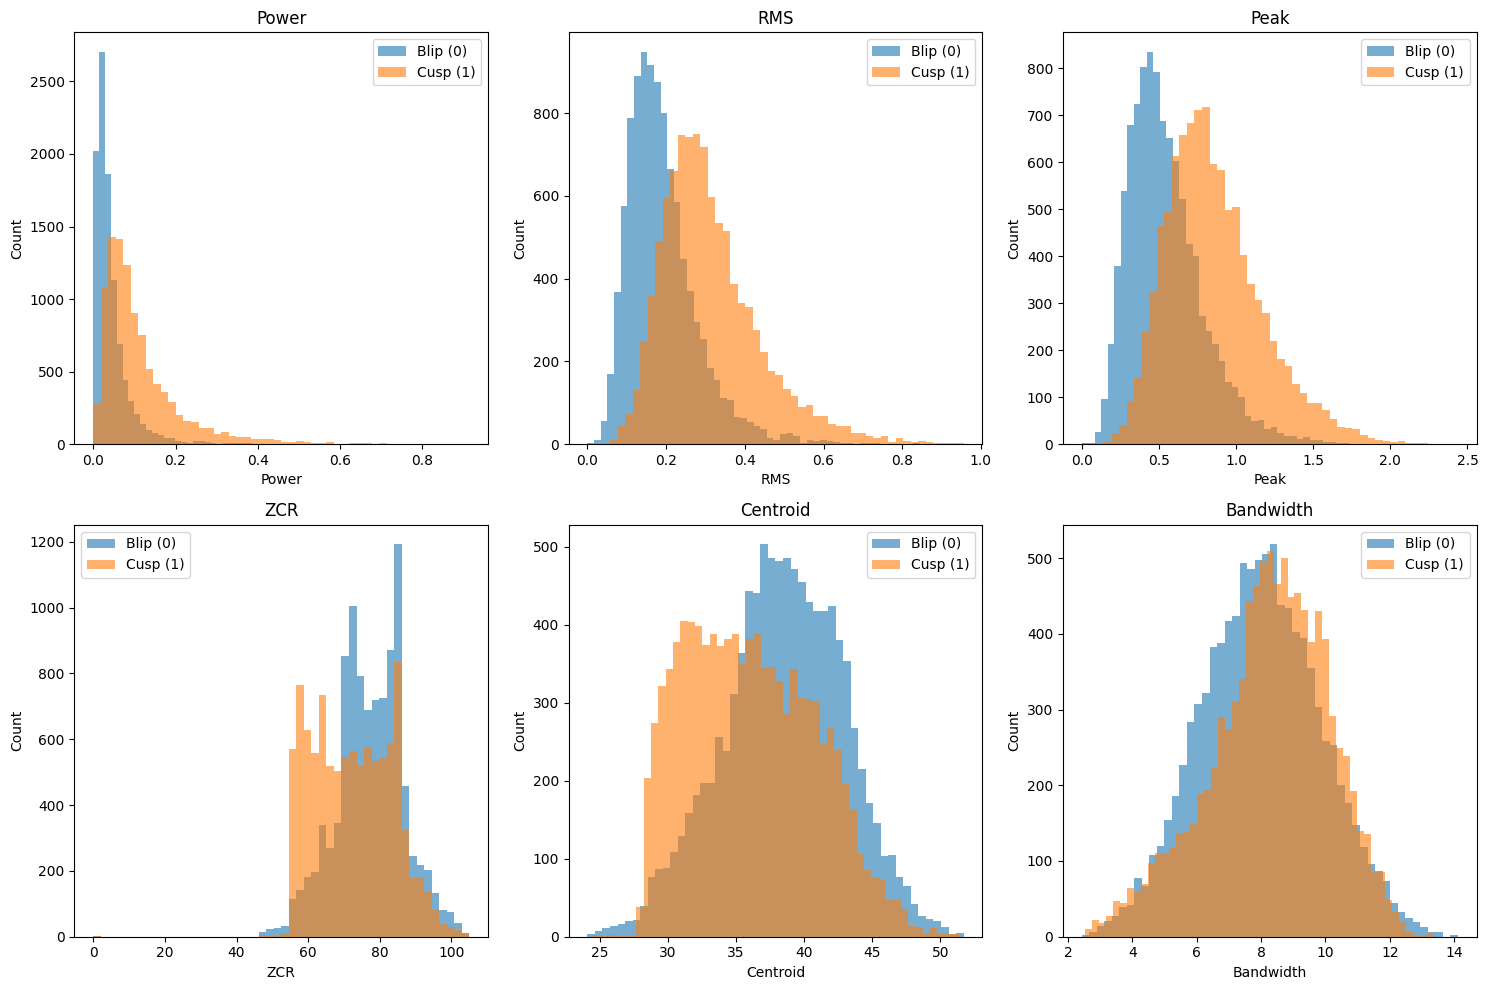

In [31]:
import matplotlib.pyplot as plt

feature_names = ["Power", "RMS", "Peak", "ZCR", "Centroid", "Bandwidth"]

cusp_feat = X_feat[y_feat == 1]
blip_feat = X_feat[y_feat == 0]

plt.figure(figsize=(15, 10))

for i, name in enumerate(feature_names):
    plt.subplot(2, 3, i + 1)
    plt.hist(blip_feat[:, i], bins=50, alpha=0.6, label='Blip (0)')
    plt.hist(cusp_feat[:, i], bins=50, alpha=0.6, label='Cusp (1)')
    plt.title(name)
    plt.xlabel(name)
    plt.ylabel("Count")
    plt.legend()

plt.tight_layout()
plt.show()